In [11]:
import jax
import jax.numpy as np
import numpy.random as npr
import scipy.stats as sps

import jax.scipy.linalg as spla
import matplotlib.pyplot as plt
import tqdm
from jax.config import config
config.update("jax_enable_x64", True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Overview

Original convex envelopes code. Next steps:
1. Implement IG objective with slice sampling in jax

Other:
* Scipy convex hulls?
* Hyperparameter opt (e.g. marginal likelihood)
* Run on a synthetic data set

In [6]:
def kernel(x1, x2, ls):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    return np.exp(-0.5*(x1.T-x2)**2/ls**2)

d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))

In [7]:
npr.seed(2)
# Number of knots to compute
knot_N = 200
# Length scale
ls = 0.1
# X points
knot_x = np.linspace(0, 1, knot_N)
# Kernel matrix
knot_K = kernel(knot_x, knot_x, ls) + 1e-8 * np.eye(knot_N)
# Cholesky decomposition
knot_cK = spla.cholesky(knot_K)

@jax.jit
def f(x, knot_y):
    cross = kernel(x, knot_x, ls)
    return cross @ spla.cho_solve((knot_cK,  False), knot_y)
D1f = jax.jit(jax.vmap(jax.grad(lambda x, y: f(x,y)[0]), in_axes=(0, None)))
D2f = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x, y: f(x,y)[0])), in_axes=(0, None)))

knot_z = npr.randn(knot_N)
knot_y = knot_cK.T @ knot_z

In [4]:
# Legendre-Fenchel Transform
deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, ls)))
s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

# Compute the convex envelope given x and y values
def convelope(knot_x, knot_y):
    knot_y = np.atleast_2d(knot_y) # samples x num_primal
    sx = s[:,np.newaxis] * knot_x[np.newaxis,:] # num_dual x num_primal
    # compute the conjugate
    lft1 = np.max(sx[np.newaxis,:,:] - knot_y[:,np.newaxis,:],  axis=2) # samples x num_dual
    # compute the biconjugate
    lft2 = np.max(sx[np.newaxis,:,:] - lft1[:,:,np.newaxis],  axis=1) # samples x num_primal
    return lft2

In [5]:
def make_preds(train_x, train_y, test_x):
    # Compute the training kernels.
    train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
    cross_K = kernel(train_x, test_x, ls)
    kappa_K = kernel(test_x, test_x, ls)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(knot_N)

    return pred_mean, pred_cov

In [8]:
def compute_mean_entropy(knot_x, pred_Y):
    mean_entropy = 0
    num_y_bins = 10
    
    u_borders = np.linspace(0, 1, num_y_bins+1)

    envelopes = convelope(knot_x, pred_Y.T)
    tights = np.abs(envelopes - pred_Y.T) < 1e-3
    p_tight = np.clip(np.mean(tights, axis=0), 1e-6, 1-1e-6)
    
    cur_entropy = -np.sum( p_tight*np.log2(p_tight) + (1-p_tight)*np.log2(1-p_tight))

    # Do this with slow loops to start out. ### TODO: modify this to compute IG with posterior
    entropy_change = []
    for nn in tqdm.tqdm(range(knot_N)):
        mean = pred_mean[nn]
        var  = pred_cov[nn,nn]
        borders = sps.norm.ppf(u_borders, loc=mean, scale=np.sqrt(var))[:,np.newaxis]
        Y = pred_Y[nn,:]
        Ybin = np.logical_and(borders[:-1] <= Y, Y < borders[1:]).T

        mean_entropy = 0
        for ii in range(num_y_bins):
            cond_p_tight = np.clip(np.mean(tights[Ybin[:,ii],:], axis=0), 1e-6, 1-1e-6)
            cond_entropy = -np.sum( cond_p_tight*np.log2(cond_p_tight) + (1-cond_p_tight)*np.log2(1-cond_p_tight))
            mean_entropy += cond_entropy/num_y_bins
        entropy_change.append(cur_entropy - mean_entropy)
    entropy_change = np.array(entropy_change)
    return entropy_change

In [9]:
def plot_results(knot_x, true_y, true_envelope, envelopes, entropy_change, knot_N, best_idx):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(knot_x,  true_y, 'k-', knot_x, pred_mean, 'b-', knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-', knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
    plt.title('True energy and current mean/std')
    
    plt.subplot(1,2,2)
    plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
    plt.title('Posterior samples')

    # Plot results
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=3)
    plt.title('Envelope samples')

    plt.subplot(1,2,2)
    plt.bar(knot_x,  entropy_change, width=(1./knot_N))
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=3)
    plt.title('Bits gained')

    plt.show()

## Try out a few iterations

100%|██████████| 200/200 [00:01<00:00, 139.64it/s]


182


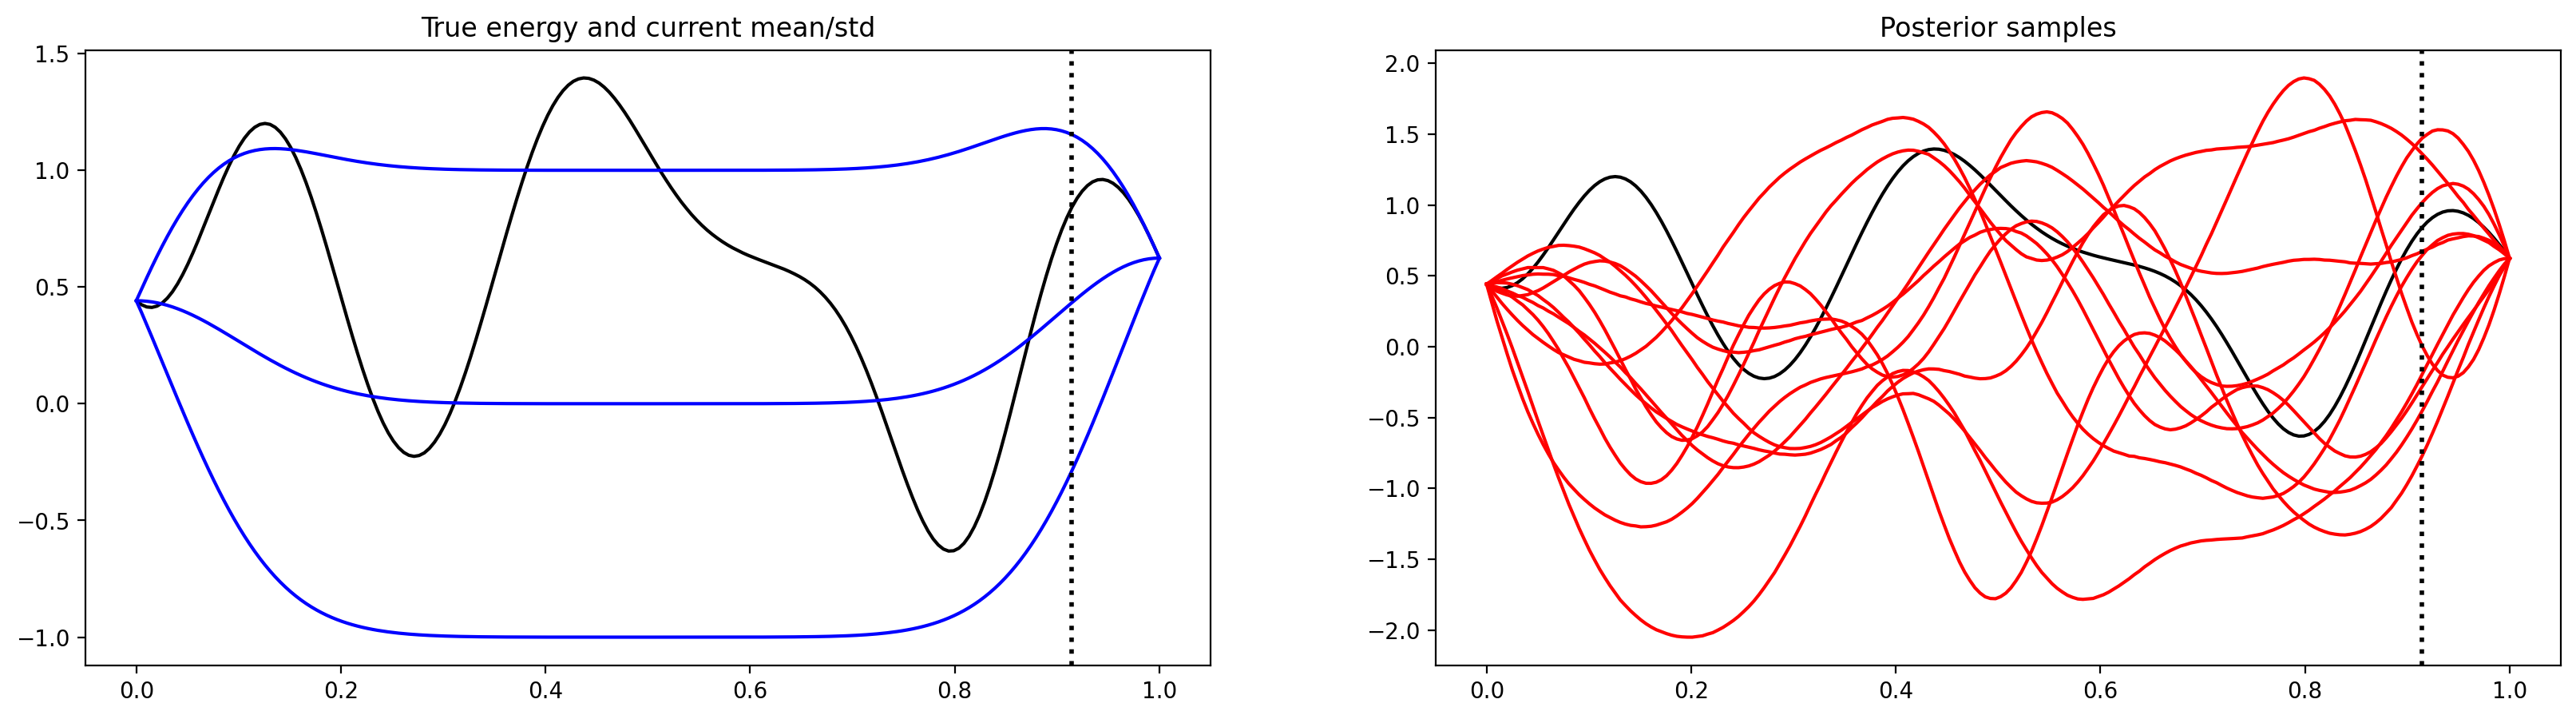

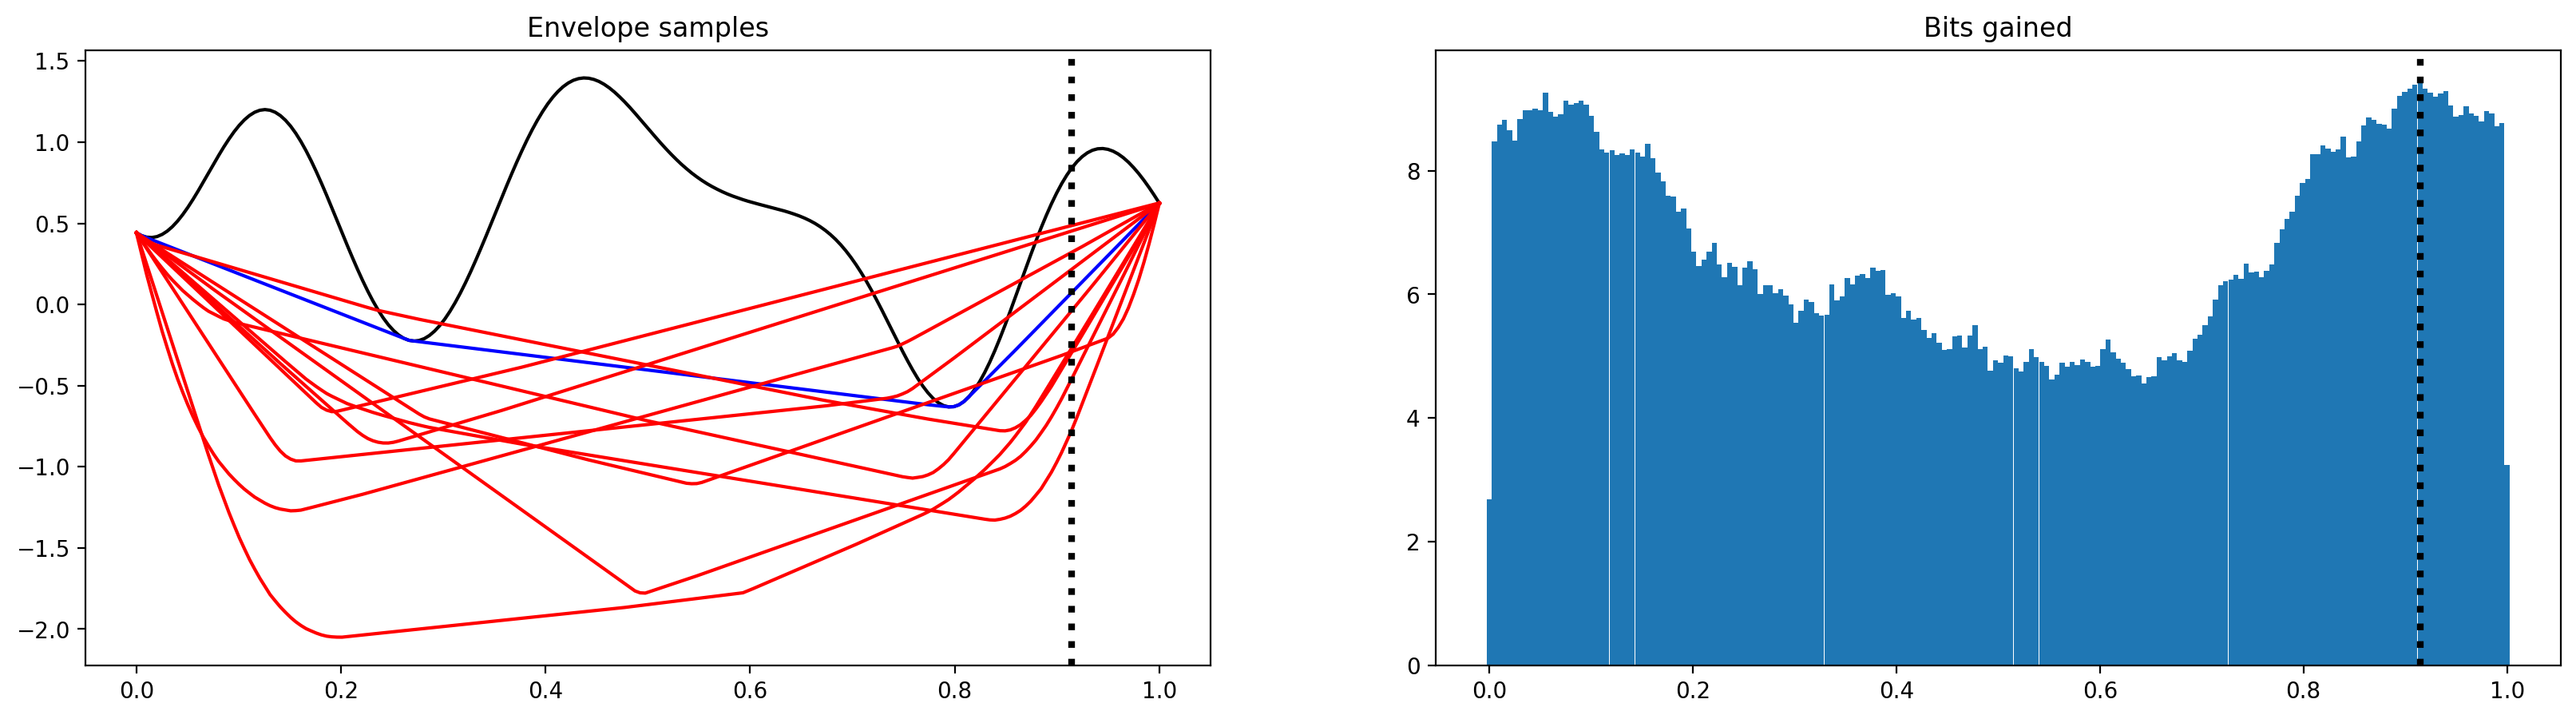

Observing:  182


100%|██████████| 200/200 [00:01<00:00, 112.84it/s]


20


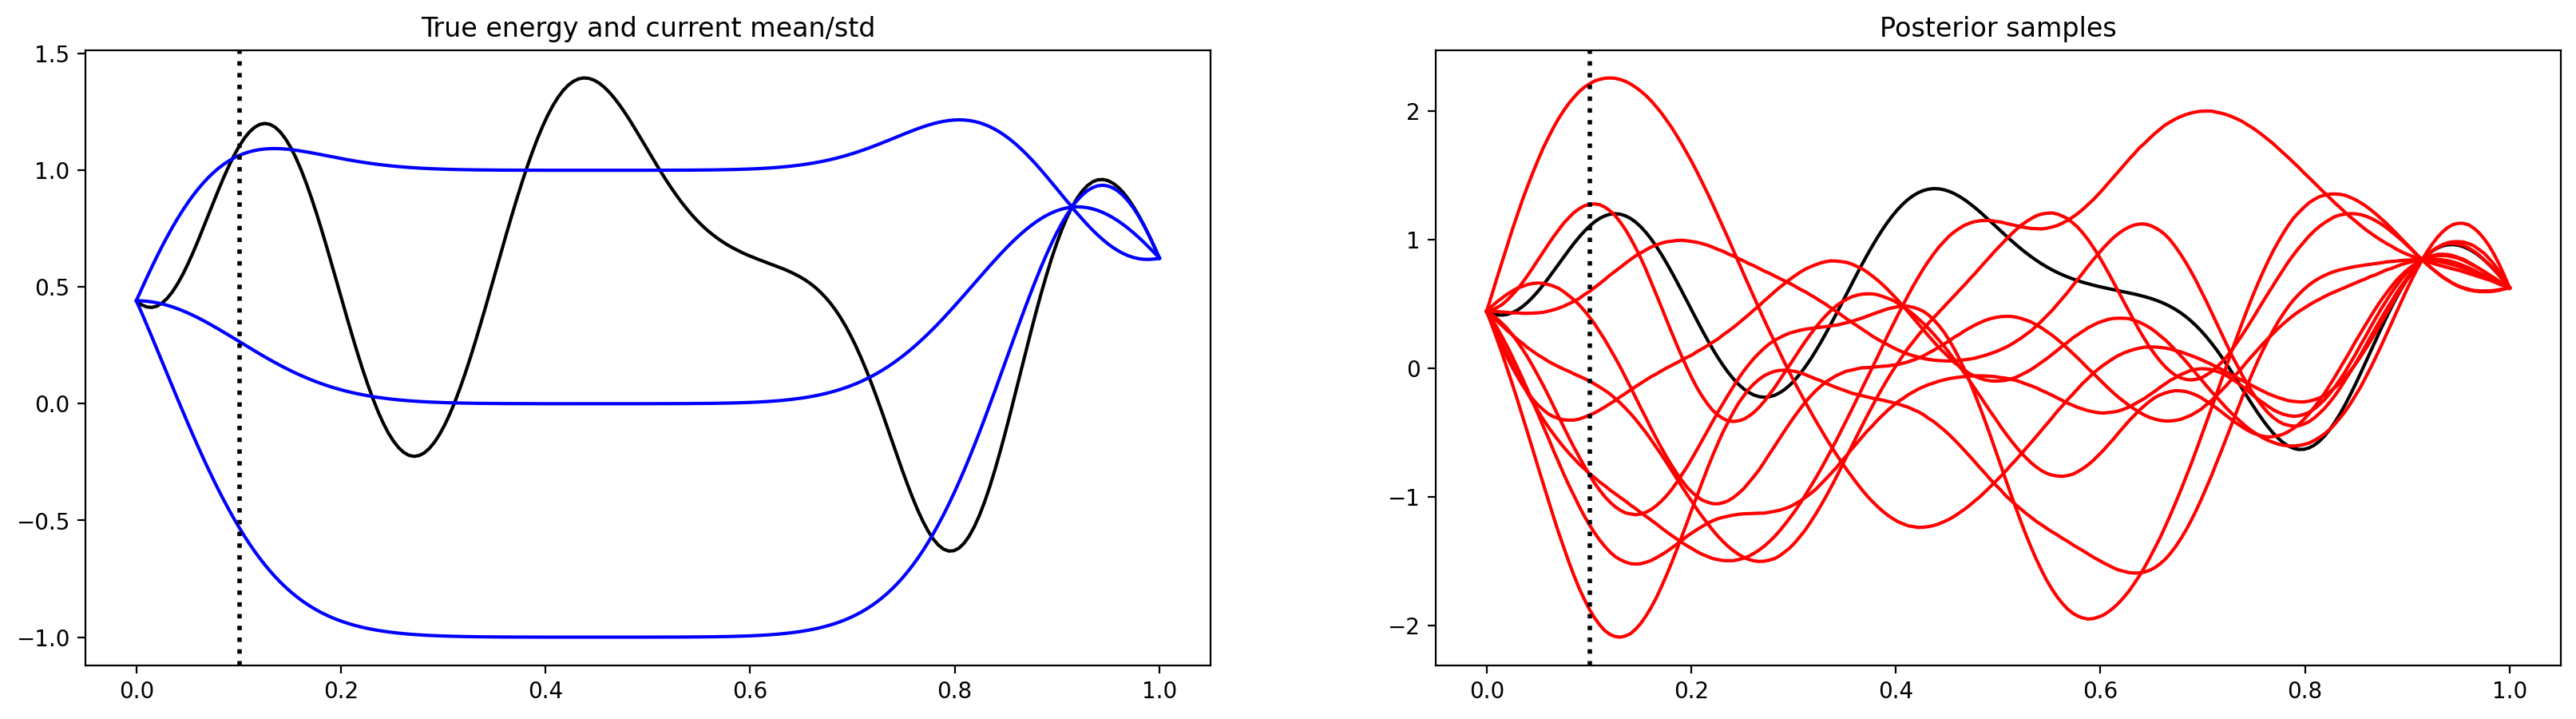

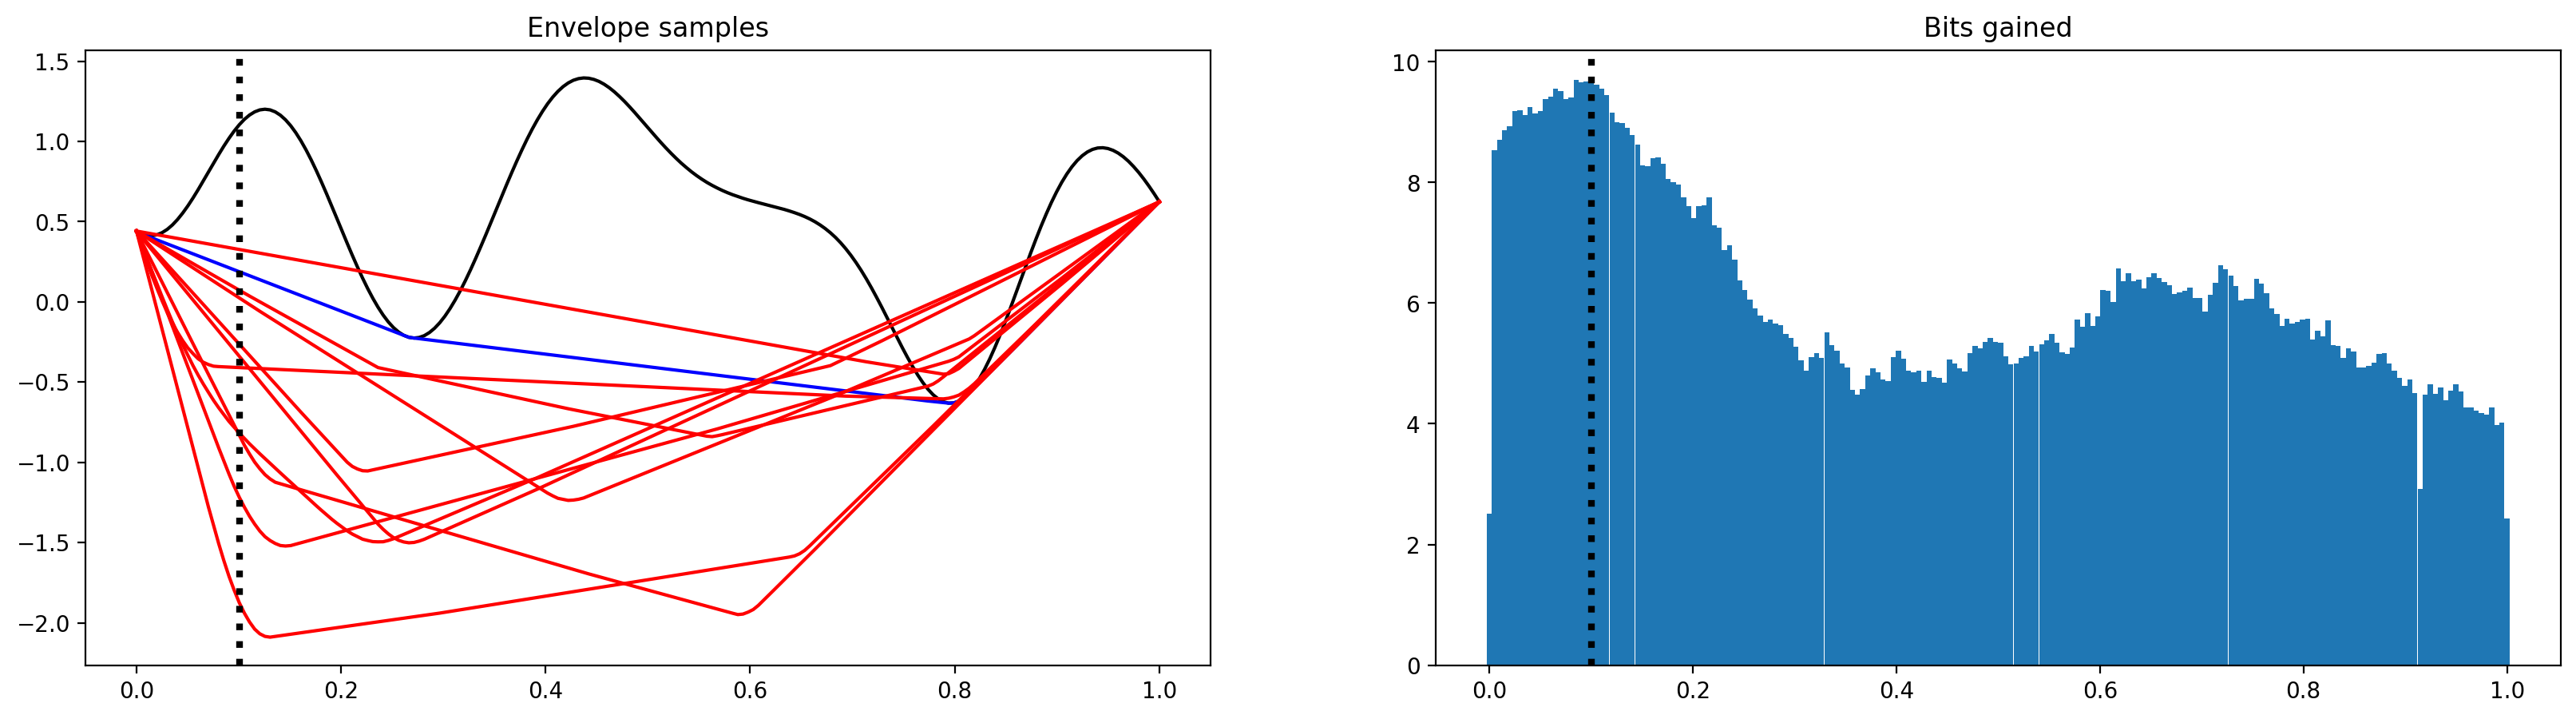

Observing:  20


100%|██████████| 200/200 [00:01<00:00, 134.81it/s]


152


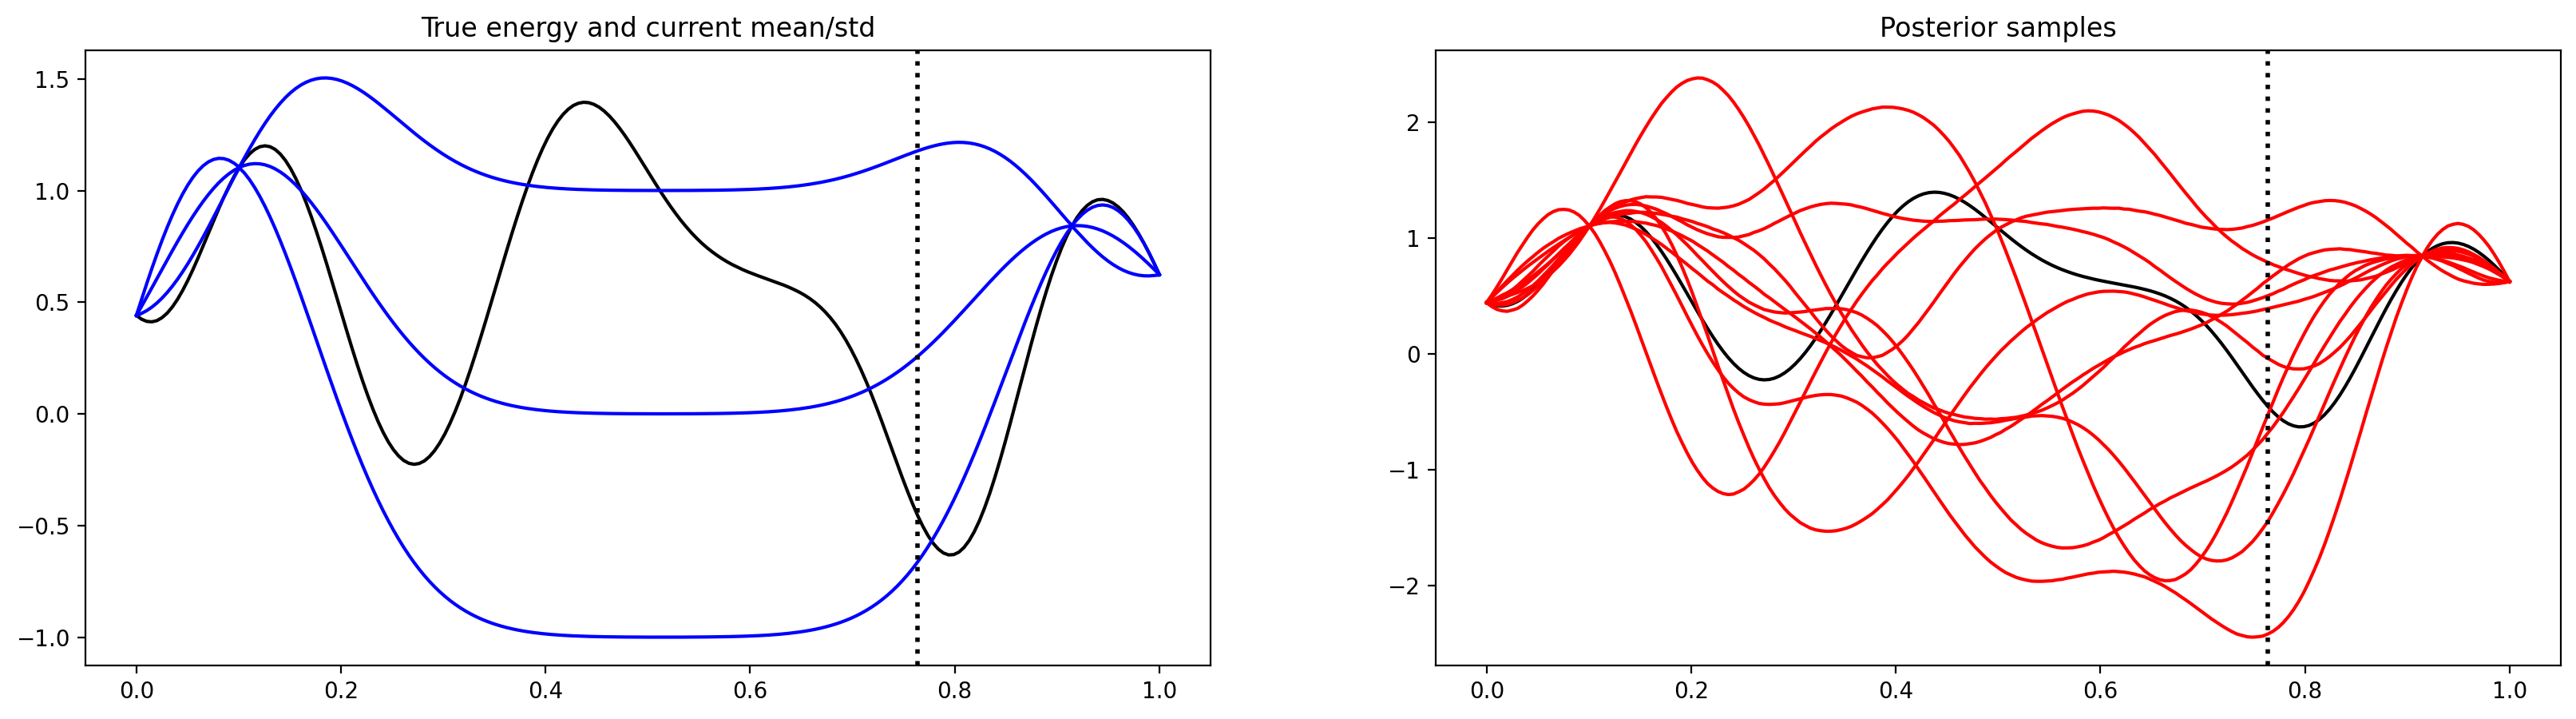

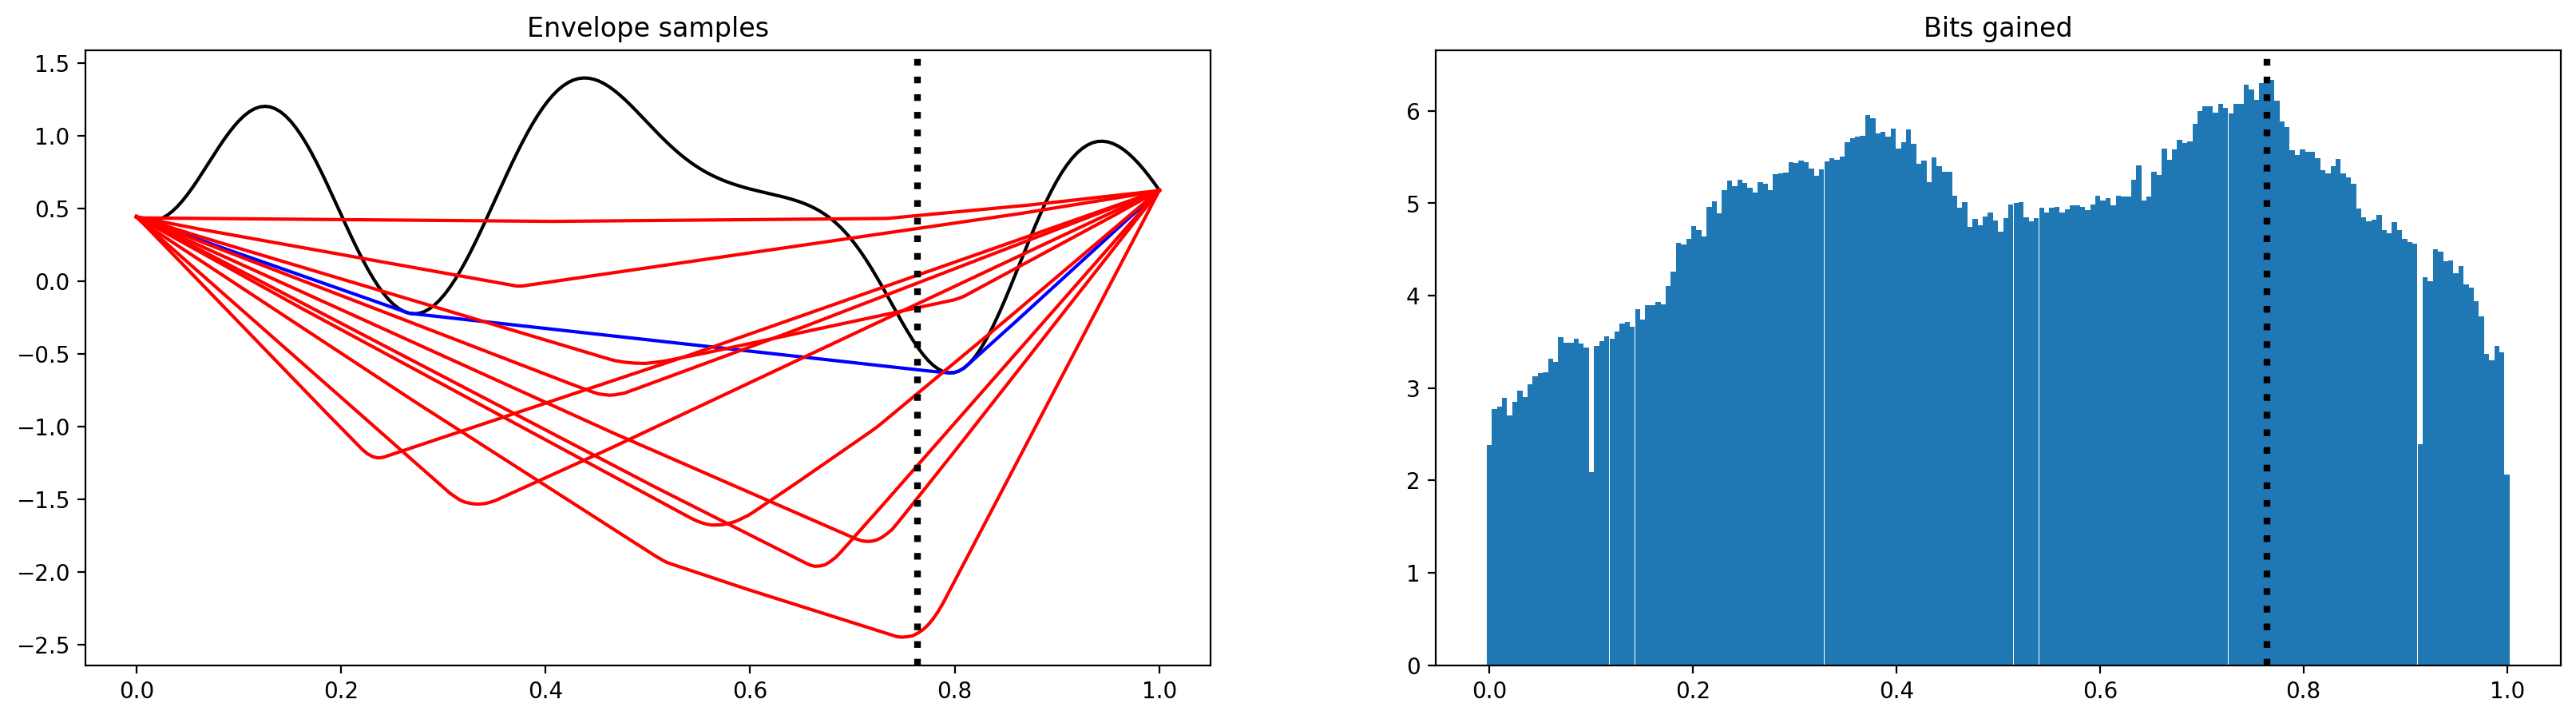

Observing:  152


100%|██████████| 200/200 [00:01<00:00, 135.85it/s]


139


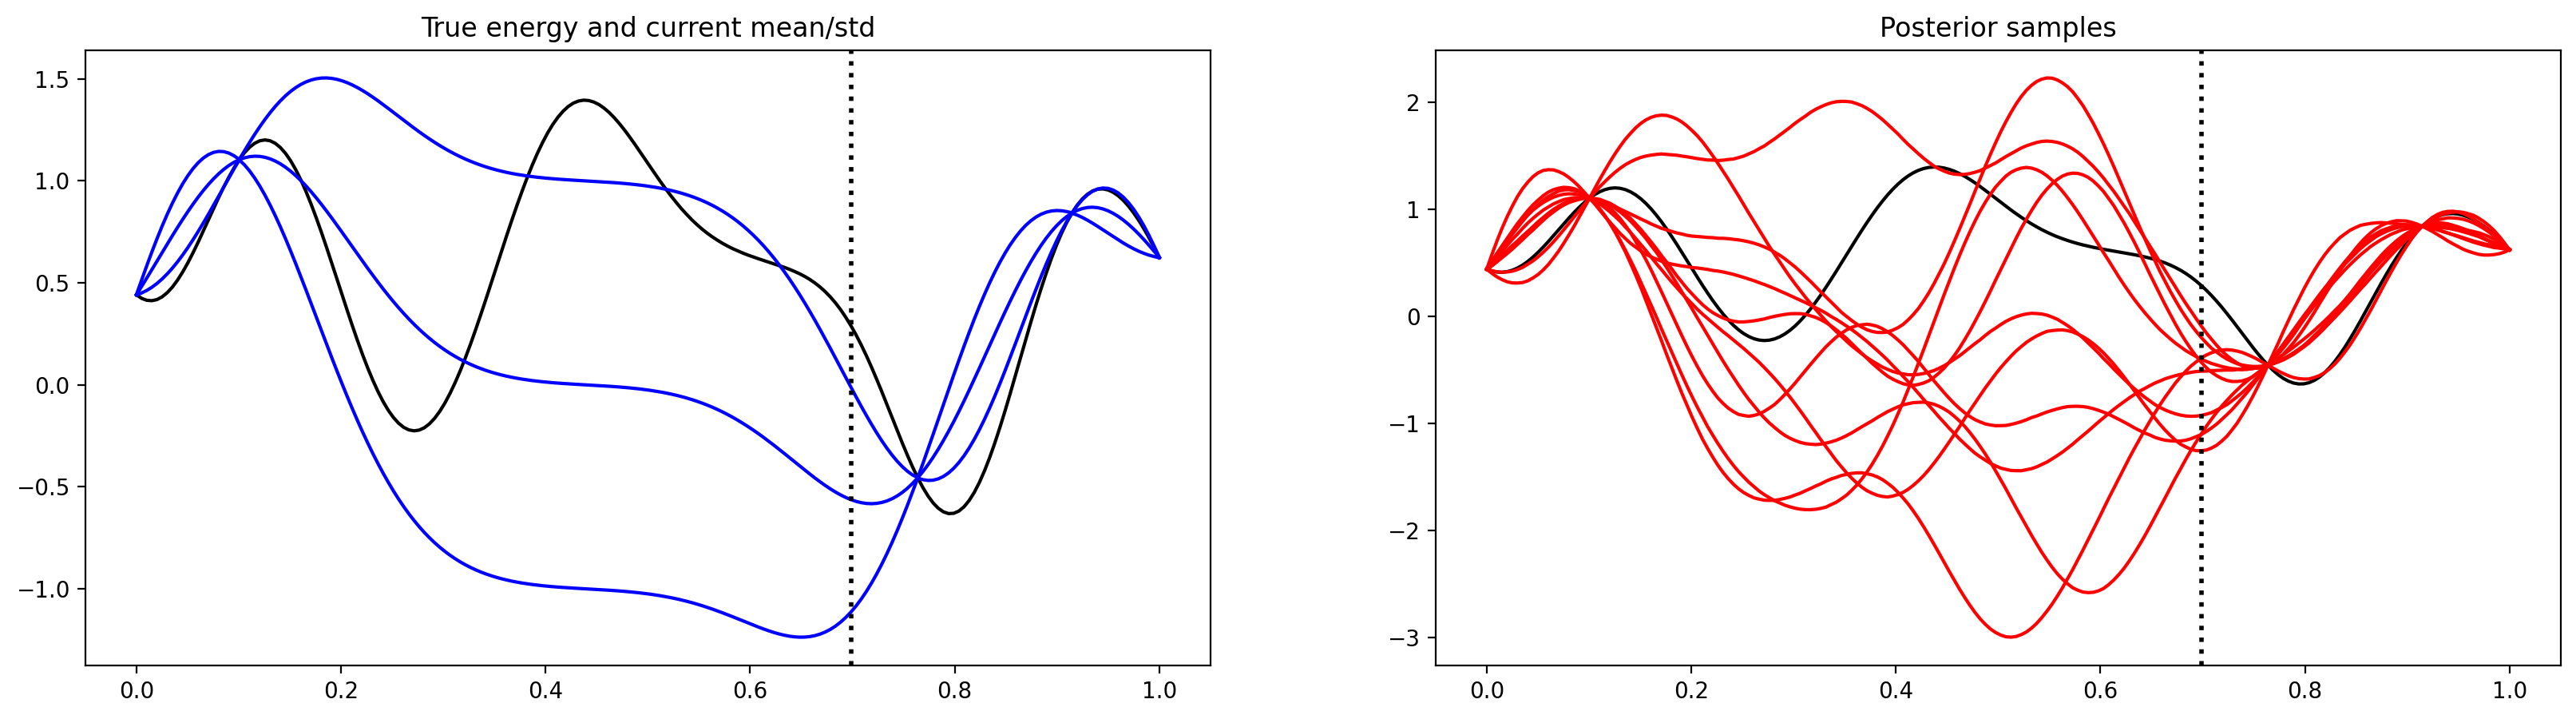

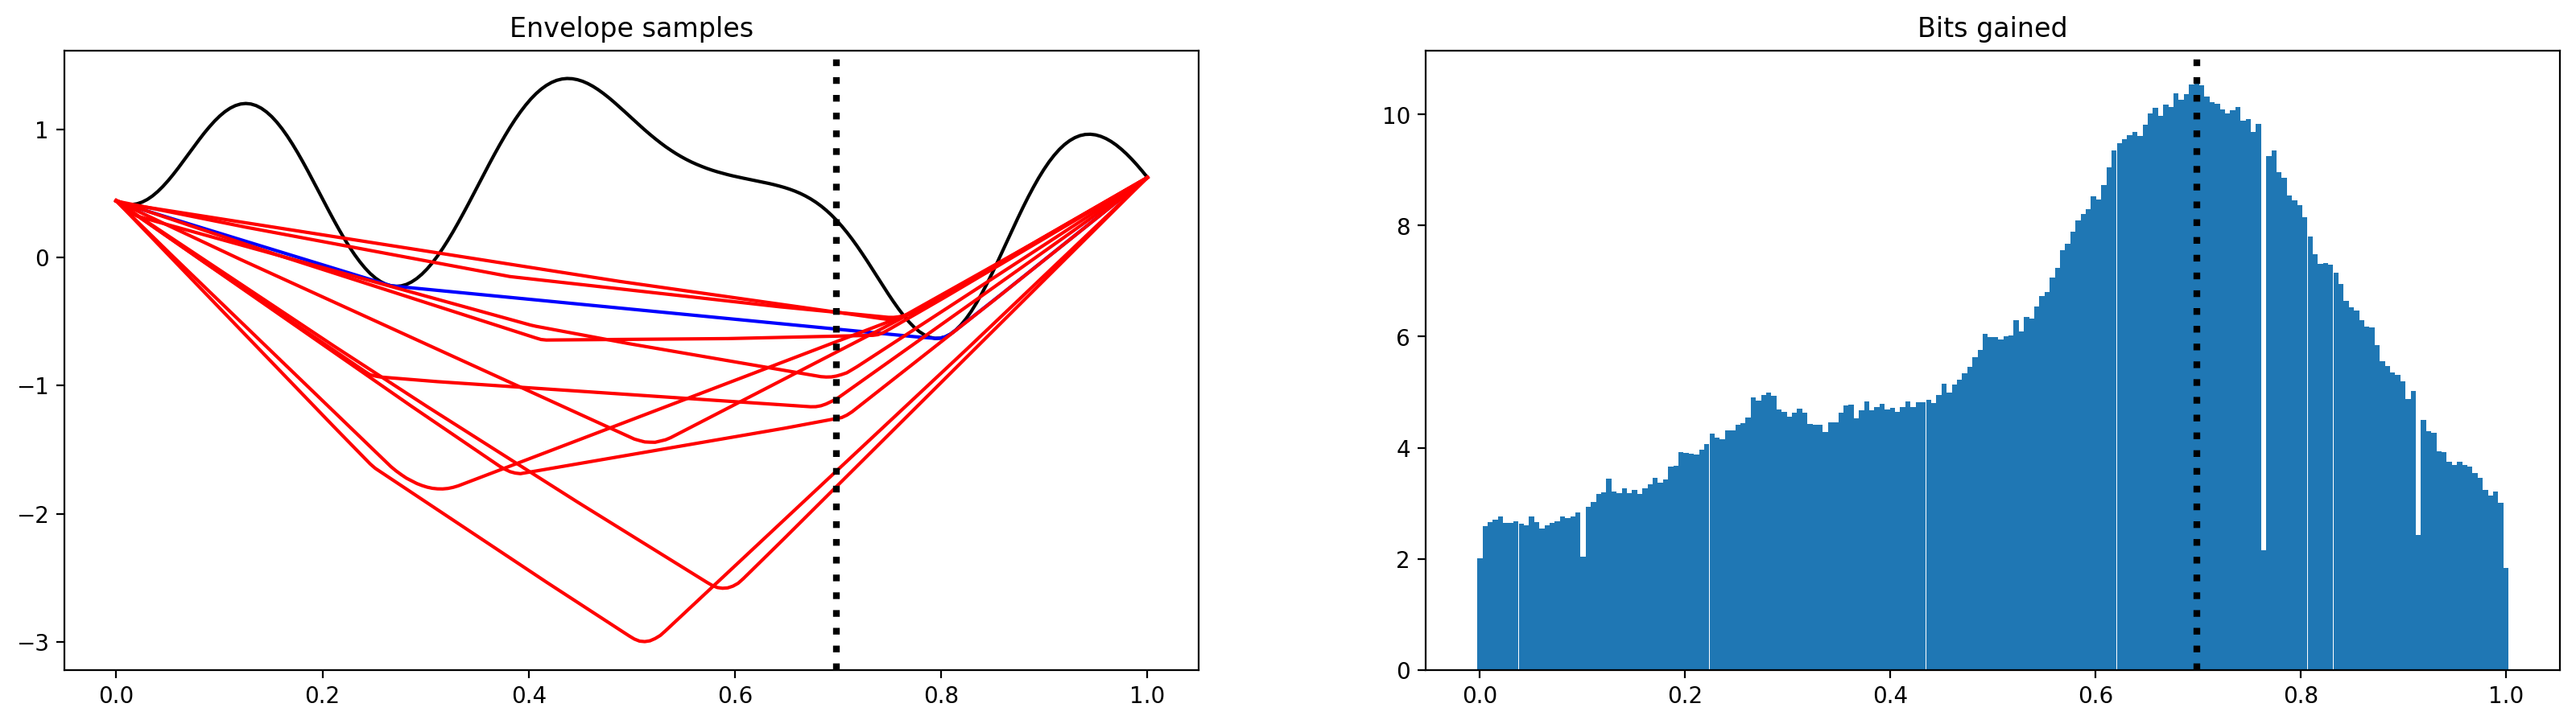

In [14]:
num_pred = 500

npr.seed(5)
# Form the true function of interest at knot_N number of points
true_y = knot_cK.T @ npr.randn(knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0], knot_x[-1]])
train_y = np.array([true_y[0], true_y[-1]])

pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

pred_cK = spla.cholesky(pred_cov)
pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]

# compute envelopes based on samples from the predictive distribution
envelopes = convelope(knot_x, pred_Y.T)
# compute envelope based on true function
true_envelope = convelope(knot_x, true_y)

# Computes a probability of tightness based on how far the predictive sample and its envelope are
#p_tight = np.clip(np.mean(np.abs(envelopes - pred_Y.T) < 1e-3, axis=0), 1e-6, 1-1e-6)

# Compute entropy change
entropy_change = compute_mean_entropy(knot_x, pred_Y)
best_idx = np.argmax(entropy_change)
print(best_idx)

plot_results(knot_x, true_y, true_envelope, envelopes, entropy_change, knot_N, best_idx)

for i in range(3):
    print("Observing: ", best_idx)

    # Make prediction at the best_idx point
    train_x = np.append(train_x, knot_x[best_idx])
    train_y = np.append(train_y, true_y[best_idx])

    pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

    pred_cK = spla.cholesky(pred_cov)
    pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]
    
    # Compute entropy change
    entropy_change = compute_mean_entropy(knot_x, pred_Y)
    best_idx = np.argmax(entropy_change)
    print(best_idx)
    
    envelopes = convelope(knot_x, pred_Y.T)
    #tights = np.abs(envelopes - pred_Y.T) < 1e-3
    #p_tight = np.clip(np.mean(tights, axis=0), 1e-6, 1-1e-6)
    
    # Plot results
    plot_results(knot_x, true_y, true_envelope, envelopes, entropy_change, knot_N, best_idx)

## Next steps

Replace the entropy computation above with IG slice sampling.

## Slice sampling 

TODO: integrate this into the above code and jit things

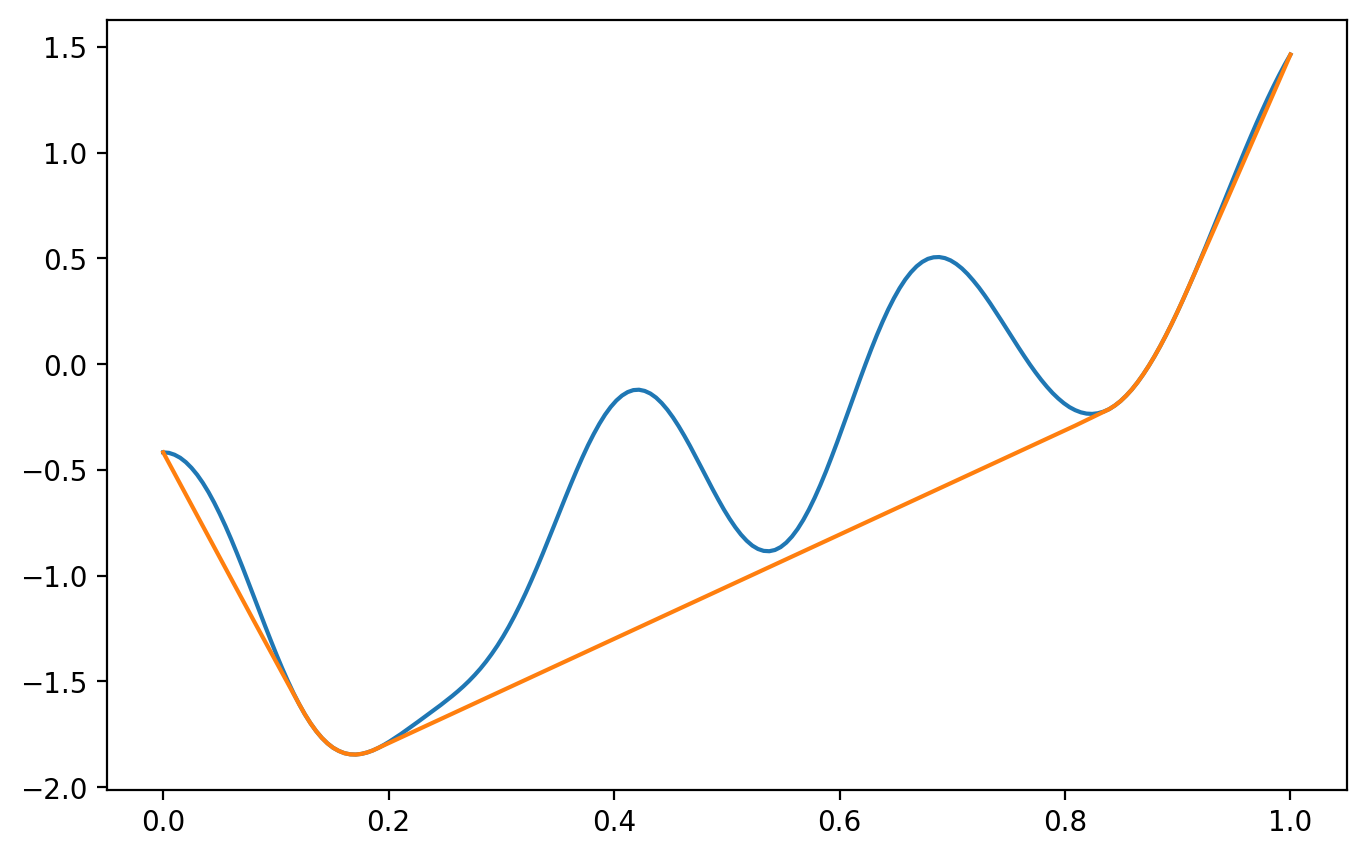

In [177]:
# Legendre-Fenchel Transform

# What range do we need to think about?
# Let's do 3 sigma.
deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, ls)))
s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

@jax.jit
def convelope(knot_x, knot_y):
  knot_y = np.atleast_2d(knot_y) # samples x num_primal
  sx = s[:,np.newaxis] * knot_x[np.newaxis,:] # num_dual x num_primal
  
  lft1 = np.max(sx[np.newaxis,:,:] - knot_y[:,np.newaxis,:],  axis=2) # samples x num_dual

  lft2 = np.max(sx[np.newaxis,:,:] - lft1[:,:,np.newaxis],  axis=1) # samples x num_primal
  return lft2

hull = convelope(knot_x, knot_y).ravel()

plt.figure(figsize=(8,5))
plt.plot(knot_x,  knot_y, knot_x, hull)

In [178]:
tight = knot_y - hull < 1e-3
def same_tight(y, tight):
    new_hull = convelope(knot_x, y).ravel()
    new_tight = y - new_hull < 1e-3
    return np.all(tight == new_tight)

def var2entropy(v):
    return 0.5*np.log(2*np.pi*v) + 0.5

"""
def make_preds(train_x, train_y, test_x):
    # Compute the training kernels.
    train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
    cross_K = kernel(train_x, test_x, ls)
    kappa_K = kernel(test_x, test_x, ls)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(knot_N)

    return pred_mean, pred_cov
"""

'\ndef make_preds(train_x, train_y, test_x):\n    # Compute the training kernels.\n    train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])\n    cross_K = kernel(train_x, test_x, ls)\n    kappa_K = kernel(test_x, test_x, ls)\n\n    # Predictive parameters.\n    train_cK = spla.cholesky(train_K)\n    cross_solve = spla.cho_solve((train_cK,  False), cross_K)\n    pred_mean = train_y.T @ cross_solve\n    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(knot_N)\n\n    return pred_mean, pred_cov\n'

In [179]:
# Rewrite this in jax.
def elliptical_slice(x0, log_lh_func, cK, num_steps):
    D = x0.shape[0]
    samples = []
    x = x0
    for ii in tqdm.tqdm(range(num_steps)):
        nu = cK.T @ npr.randn(D)
        u = npr.rand()
        log_y = log_lh_func(x) + np.log(u)
        theta = npr.rand() * 2 * np.pi
        upper = theta
        lower = theta - 2 * np.pi
        shrinks = 0
        while True:
            theta = npr.rand()*(upper-lower) + lower
            new_x = x * np.cos(theta) + nu * np.sin(theta)
            if log_lh_func(new_x) > log_y:
                x = new_x
                break
            else:
                shrinks = shrinks + 1
                if theta > 0:
                    upper = theta
                else:
                    lower = theta
            if ii % 100 == 0:
                print(ii, shrinks, theta)
            samples.append(x)
    return np.array(samples)

  8%|▊         | 25/300 [00:00<00:02, 131.02it/s]

0 1 -2.8553143651732866
0 2 -1.717564883800355
0 3 -0.2432446216735611
0 4 1.0139992996713139
0 5 0.7263381011952154
0 6 0.35449113466354765
0 7 0.023416238704937586
0 8 -0.166488323819297
0 9 -0.009786904029516486
0 10 -0.004886869670280944
0 11 0.008688480721262885


 45%|████▍     | 134/300 [00:00<00:00, 245.59it/s]

100 1 -0.1119070611517885
100 2 0.2508719523014678
100 3 0.1838727126665619
100 4 -0.08295166634147313
100 5 -0.012894302210612482
100 6 0.03079964834929981


 76%|███████▌  | 228/300 [00:00<00:00, 276.70it/s]

200 1 -0.6946611693222566
200 2 0.18120295608930004
200 3 -0.3759759373690029
200 4 -0.2510649520489524
200 5 -0.08231189484510607
200 6 0.025570791502635318
200 7 0.00436415851971908
200 8 -0.021510414708562
200 9 -0.01286713354133383
200 10 -0.004929102916737092


100%|██████████| 300/300 [00:01<00:00, 246.00it/s]


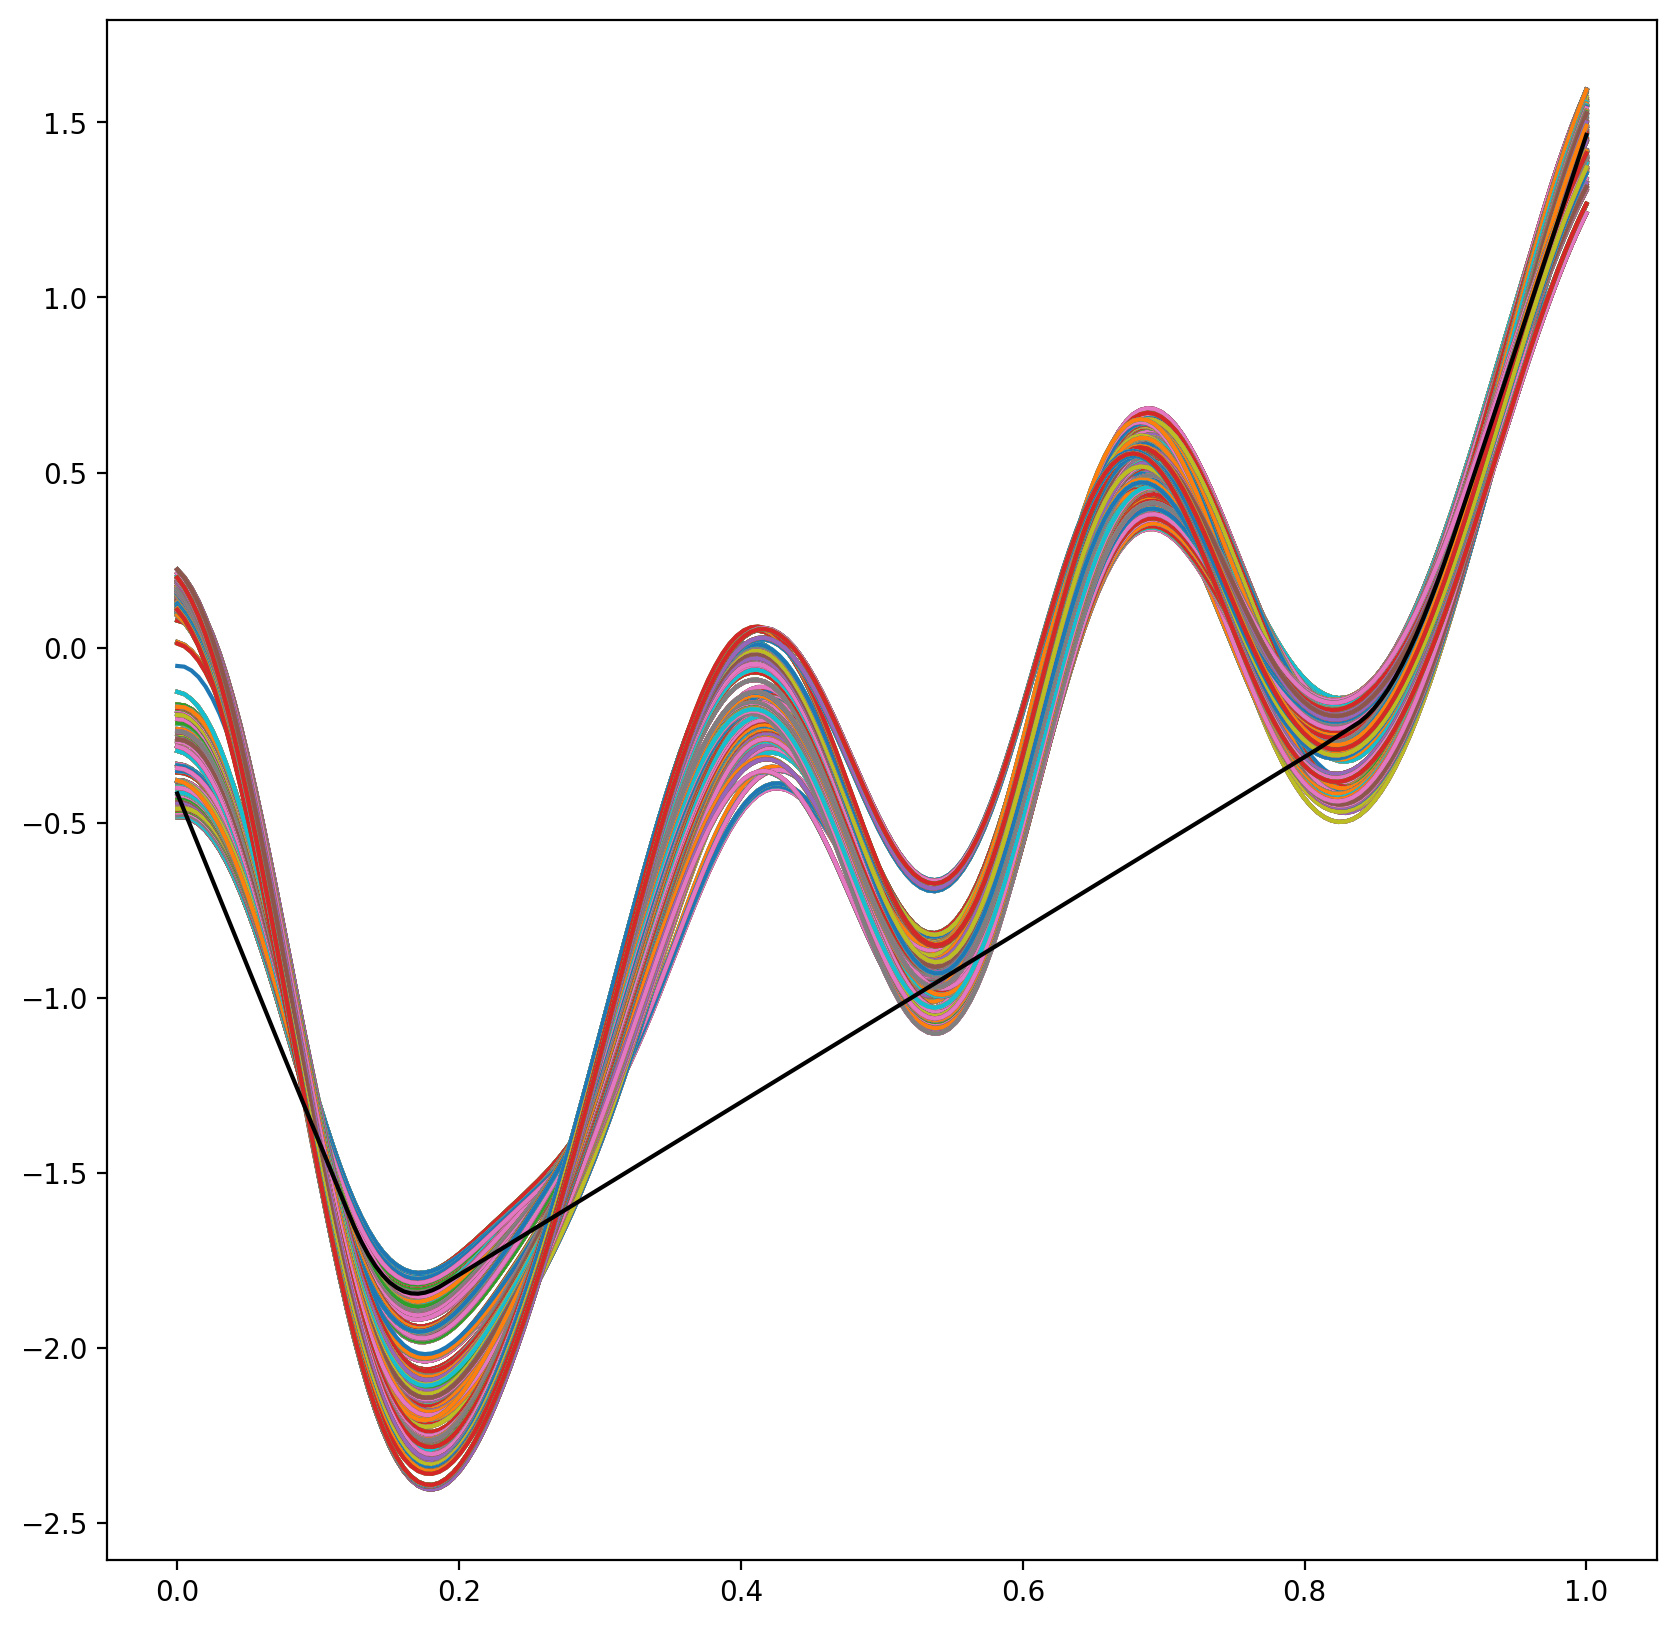

In [180]:
samples = elliptical_slice(knot_y, lambda x: np.log(same_tight(x, tight)), knot_cK, 300)
plt.figure(figsize=(10,10))
plt.plot(knot_x, samples.T, knot_x, hull, 'k-')
plt.show()

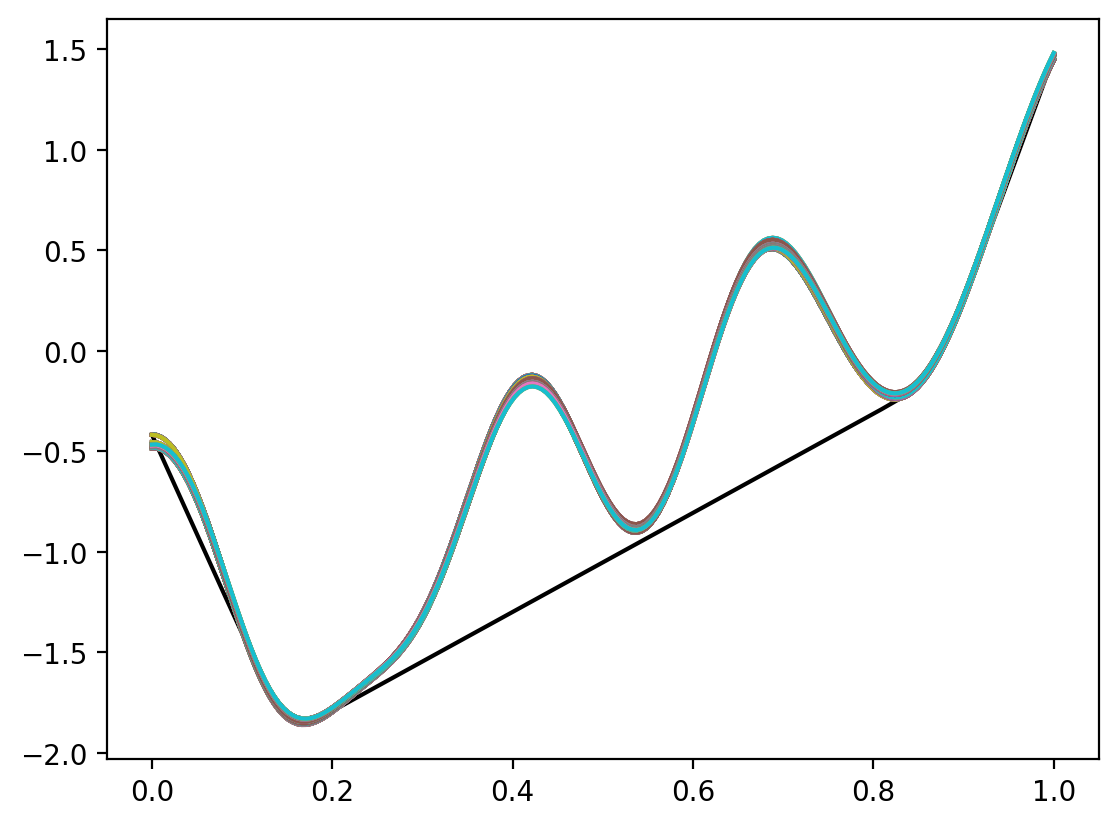

In [192]:
plt.plot(knot_x, hull, 'k-')

for i in range(200):
    plt.plot(knot_x, samples[i,:])

In [184]:
 samples.T.shape

(200, 2624)